# Analisis de supervivencia en el RMS Titanic
El RMS Titanicnota 1 fue un transatlántico británico, el mayor barco del mundo al finalizar su construcción, que se hundió en la noche del 14 a la madrugada del 15 de abril de 1912 durante su viaje inaugural desde Southampton a Nueva York. En el hundimiento del Titanic murieron 1514 personas de las 2223 que iban a bordo, lo que convierte a esta tragedia en uno de los mayores naufragios de la historia ocurridos en tiempo de paz. Construido entre 1909 y 1912 en el astillero Harland and Wolff de Belfast, el Titanic era el segundo de los tres transatlánticos que formaban la clase Olympic, propiedad de la naviera White Star Line, junto al RMS Olympic y, posteriormente, el HMHS Britannic.

A continuación, se utilizara un set de datos el cual contiene un listado de los pasajeros que estuvieron abordo del Titanic para anlizar la supervivenvia de los pasajeros segun ciertas caracteristicas (Sexo, edad, cabina, embarcación, entre otras).

En este Notebook, utilizaremos ademas, la libreria Scikit-Learn para el procesamiento de datos, y la predicción de nuevos datos sin etiquetar (Determinar la probabilidad de supervivencia) los cuales se encuantran en el conjunto de datos de prueba.

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
data_train = pd.read_csv('train.csv') # Datos de entrenamiento
data_test = pd.read_csv('test.csv') # Datos de Prueba

In [35]:
data_train.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
34,35,0,1,"Meyer, Mr. Edgar Joseph",male,28.0,1,0,PC 17604,82.1708,NaN,C
171,172,0,3,"Rice, Master. Arthur",male,4.0,4,1,382652,29.1250,NaN,Q
248,249,1,1,"Beckwith, Mr. Richard Leonard",male,37.0,1,1,11751,52.5542,D35,S


## Visualización de datos

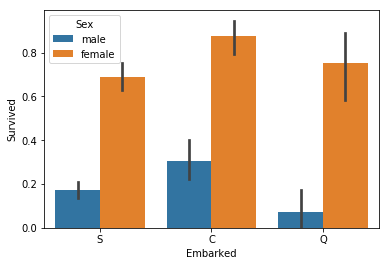

In [36]:
sns.barplot(x="Embarked", y="Survived", hue="Sex", data=data_train)

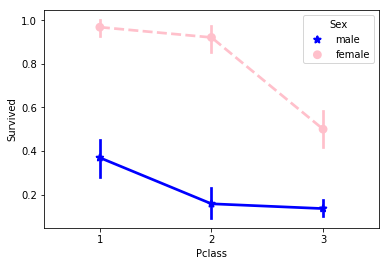

In [37]:
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=data_train,
                 palette={"male": "blue", "female": "pink"},
                  markers=["*", "o"], linestyles=["-", "--"])

## Transformando caracteristicas

In [38]:
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df    
    
def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

data_train = transform_features(data_train)
data_test = transform_features(data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,male,Student,1,0,1_quartile,N,"Braund,",Mr.
1,2,1,1,female,Adult,1,0,4_quartile,C,"Cumings,",Mrs.
2,3,1,3,female,Young Adult,0,0,1_quartile,N,"Heikkinen,",Miss.
3,4,1,1,female,Young Adult,1,0,4_quartile,C,"Futrelle,",Mrs.
4,5,0,3,male,Young Adult,0,0,2_quartile,N,"Allen,",Mr.


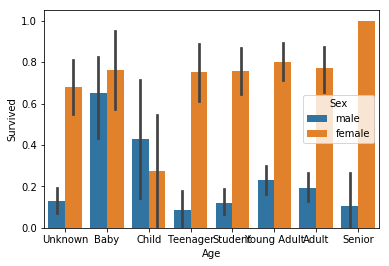

In [39]:
sns.barplot(x="Age", y="Survived", hue="Sex", data=data_train)

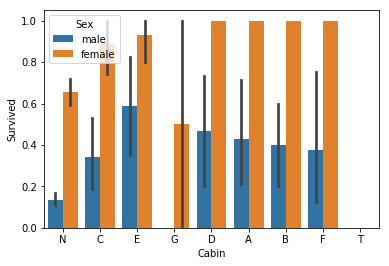

In [40]:
sns.barplot(x="Cabin", y="Survived", hue="Sex", data=data_train)

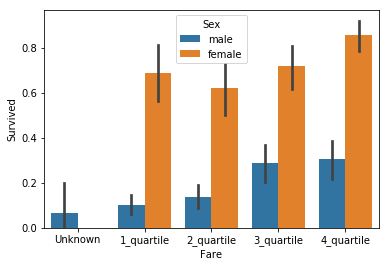

In [41]:
sns.barplot(x="Fare", y="Survived", hue="Sex",data=data_train)

## Codificación Final

La última parte de la fase de preprocesamiento es normalizar las etiquetas. El LabelEncoder en Scikit-learn convertirá cada valor de cadena único en un número, lo que hace que los datos sean más flexibles para varios algoritmos.

El resultado es una tabla de números que da miedo a los humanos, pero es hermosa para las máquinas.

In [42]:
from sklearn import preprocessing
def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test
    
data_train, data_test = encode_features(data_train, data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,1,4,1,0,0,7,100,19
1,2,1,1,0,0,1,0,3,2,182,20
2,3,1,3,0,7,0,0,0,7,329,16
3,4,1,1,0,7,1,0,3,2,267,20
4,5,0,3,1,7,0,0,1,7,15,19


## División de los datos de entrenamiento
Ahora es tiempo de que las maquinas aprendan.

Primero, separe las características (X) de las etiquetas (y).

X_all: todas las características menos el valor que queremos predecir (Sobrevivido).

y_all: solo el valor que queremos predecir

Segundo, use Scikit-learn para mezclar aleatoriamente estos datos en cuatro variables. En este caso, estoy entrenando el 80% de los datos, luego probando contra el otro 20%.

Más tarde, estos datos se reorganizarán en un patrón de KFold para validar la efectividad de un algoritmo entrenado.

In [43]:
from sklearn.model_selection import train_test_split

X_all = data_train.drop(['Survived', 'PassengerId'], axis=1)
y_all = data_train['Survived']

num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=23)

## Entrenando al Algoritmo
Ahora es el momento de descubrir qué algoritmo ofrecerá el mejor modelo. Voy con el RandomForestClassifier, pero puedes soltar cualquier otro clasificador aquí, como Support Vector Machines o Naive Bayes.

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()

parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

acc_scorer = make_scorer(accuracy_score)

grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

clf = grid_obj.best_estimator_

clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            n_estimators=4, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [29]:
predicton = clf.predict(X_test)
accuracy_score(y_test ,predicton)

0.79329608938547491

## Predecir los datos de prueba reales

In [32]:
ids = data_test['PassengerId']
predictions = clf.predict(data_test.drop('PassengerId', axis=1))


output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
output.to_csv('titanic-predictions.csv', index = False)
output.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
